In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.arima.model import ARIMA

In [1]:
import shap

In [4]:
import openpyxl
# Load the currency exchange rate dataset
exchange_rate_dataset = pd.read_excel('FX_FanU.xlsx', skiprows=3)
interested_currencies = ['Name', 'CANADIAN', 'EURO', 'UK', 'YEN', 'KRONA', 'SINGAPORE']

# Filter columns based on whether the header contains a G10 country
filtered_columns = [col for col in exchange_rate_dataset.columns if any(country in col for country in interested_currencies)]

# Select only the filtered columns in the DataFrame
fx_filtered = exchange_rate_dataset[filtered_columns]
fx_filtered = fx_filtered.drop([0, 1]).reset_index(drop = True)
fx_filtered.rename(columns={'Name': 'Date'}, inplace=True)

# Retain only Date
fx_filtered['Date'] = fx_filtered['Date'].astype(str)
fx_filtered['Date'] = fx_filtered['Date'].str.split(' ').str[0]

# Save filtered csv
fx_filtered.reset_index(drop = True)
fx_filtered.to_csv("fx_filtered.csv", index=False)

fx_filtered_train = fx_filtered[(fx_filtered['Date'] >= '2017-12-25') & (fx_filtered['Date'] <= '2018-12-31')]
fx_filtered_test = fx_filtered[(fx_filtered['Date'] >= '2019-12-25')]

In [5]:
currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE", 
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"}

In [6]:
# Extract and store the 'Date' column
dates = fx_filtered_train['Date']
test_dates = fx_filtered_test['Date']

# Iterate through the columns and create individual DataFrames
individual_dict, test_dict = {},{}
for column in fx_filtered_train.iloc[:, 1:]:
    individual_dict[column] = pd.DataFrame({column: fx_filtered_train[column]})

for column in fx_filtered_test.iloc[:, 1:]:
    test_dict[column] = pd.DataFrame({column: fx_filtered_test[column]})

In [7]:
# Define a custom dataset and dataloader
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (
            self.data[idx:idx+self.seq_length],
            self.data[idx+self.seq_length]
        )

In [8]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Run below to change currency

In [9]:
# Normalize the data
scaler = MinMaxScaler()

selection=""
while selection not in currency.keys():
    selection = input("Select currency from [CA, FR, DE, IT, NL, BE, UK, JP, SE, SG]: ").upper()

country = currency[selection]
country_df = individual_dict[country]
country_df = country_df.set_index(dates)
country_test_df = test_dict[country]
country_test_df = country_test_df.set_index(test_dates)

country_df_scaled = scaler.fit_transform(country_df)
country_test_df_scaled = scaler.fit_transform(country_test_df)

# Convert the data to PyTorch tensors
tensor_data = torch.FloatTensor(country_df_scaled)
tensor_test_data = torch.FloatTensor(country_test_df_scaled)

In [12]:

# Create dataset and dataloader
seq_length = 5
dataset = TimeSeriesDataset(tensor_data, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

test_dataset = TimeSeriesDataset(tensor_test_data, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# Instantiate the model, define loss function and optimizer
input_size = seq_length
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# arima_model = ARIMA(country_df, order=(1, 1, 1))  # Replace p, d, q with appropriate values
# arima_result = arima_model.fit()
# arima_predictions = arima_result.plot_predict(dynamic=False)
# arima_mse = mean_squared_error(country_test_df[country], arima_predictions)
# print(f'ARIMA MSE: {arima_mse}')

In [12]:
# Training the model
num_epochs = 35
for epoch in range(num_epochs):
    for inputs, target in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/35], Loss: 0.6390
Epoch [2/35], Loss: 0.4421
Epoch [3/35], Loss: 0.2413
Epoch [4/35], Loss: 0.1007
Epoch [5/35], Loss: 0.0741
Epoch [6/35], Loss: 0.0985
Epoch [7/35], Loss: 0.1119
Epoch [8/35], Loss: 0.1024
Epoch [9/35], Loss: 0.0857
Epoch [10/35], Loss: 0.0742
Epoch [11/35], Loss: 0.0684
Epoch [12/35], Loss: 0.0628
Epoch [13/35], Loss: 0.0548
Epoch [14/35], Loss: 0.0457
Epoch [15/35], Loss: 0.0372
Epoch [16/35], Loss: 0.0294
Epoch [17/35], Loss: 0.0218
Epoch [18/35], Loss: 0.0148
Epoch [19/35], Loss: 0.0090
Epoch [20/35], Loss: 0.0047
Epoch [21/35], Loss: 0.0020
Epoch [22/35], Loss: 0.0008
Epoch [23/35], Loss: 0.0006
Epoch [24/35], Loss: 0.0009
Epoch [25/35], Loss: 0.0011
Epoch [26/35], Loss: 0.0011
Epoch [27/35], Loss: 0.0010
Epoch [28/35], Loss: 0.0010
Epoch [29/35], Loss: 0.0009
Epoch [30/35], Loss: 0.0008
Epoch [31/35], Loss: 0.0008
Epoch [32/35], Loss: 0.0008
Epoch [33/35], Loss: 0.0008
Epoch [34/35], Loss: 0.0008
Epoch [35/35], Loss: 0.0008


In [13]:
torch.save(model.state_dict(), fr'{selection}_model.pth')
print("Model saved!")

Model saved!


In [3]:
model.load_state_dict(torch.load(fr'{selection}_model.pth'))

# Evaluation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():  # Disable gradient calculation during evaluation
    # Initialize a list to store values
    inputs_list, pred_actual_list = [], []

    # Iterate through the dataset for evaluation
    for inputs, target in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        # Accumulate the test loss
        test_loss += loss.item()
        
        # Inverse transform the scaled prediction
        pred_actual = scaler.inverse_transform(np.concatenate((inputs.squeeze().numpy(), outputs.squeeze().numpy().reshape(-1, 1)), axis=1))[:, -1]
        
        # Append the predicted values to the list
        pred_actual_list.append(pred_actual)

# Calculate the average test loss
avg_test_loss = test_loss / len(test_dataloader)

# Print the average test loss
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Flatten the list of predictions
pred_actual = np.concatenate(pred_actual_list)

NameError: name 'model' is not defined

In [15]:
pred_df = pd.DataFrame(list(zip(test_dates.iloc[5:],pred_actual)))
pred_df.to_excel( selection + "_pred.xlsx")

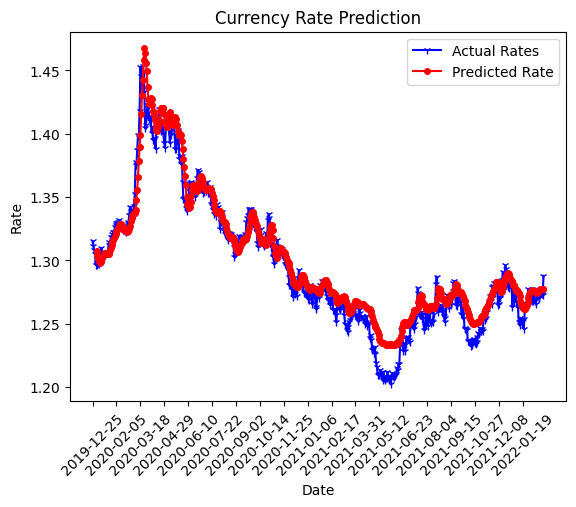

In [16]:
plt.plot(test_dates, country_test_df[country], marker='1', label='Actual Rates', color='blue')
plt.plot(test_dates.iloc[5:],  pred_actual, marker='.', markersize=8, label='Predicted Rate', color='red')
plt.title('Currency Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
interval = 30
# interval = 10
plt.xticks(test_dates.iloc[::interval], rotation=45)
# plt.xlim(test_dates.iloc[0], test_dates.iloc[100])
plt.show()

## Work on Oxford Dataset

In [17]:
# Load the OxCGRT dataset
dtypes = {'RegionName': str, 'RegionCode': str}
oxcg_dataset = pd.read_csv('OxCGRT_compact_national_v1.csv', dtype=dtypes)
interested_countries = ['Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Belgium', 'United Kingdom', 'Japan', 'Sweden', 'Singapore']

# Filter the dataset to include only the G10 countries and Singapore
oxcg_filtered = oxcg_dataset[oxcg_dataset['CountryName'].isin(interested_countries)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)

# List of columns to drop
columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]

# Drop unwanted columns
oxcg_filtered = oxcg_filtered.drop(columns=columns_to_drop)

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

for group_name, group_data in grouped:
    country = f"Countries data\\{group_name}_policy.csv"
    group_data.to_csv(country)

# Save filtered csv
oxcg_filtered.to_csv("OxCGRT_compact_national_v1_filtered.csv")

C:\Users\Omer Habib\AppData\Local\Temp\ipykernel_7876\3135542131.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)
C:\Users\Omer Habib\AppData\Local\Temp\ipykernel_7876\3135542131.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))
C:\Users\Omer Habib\AppData\Local\Temp\ipykernel_7876\3135542131.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the futu

In [18]:
country = {"CA": ["Canada", "CAD"], 
            "FR": ["France", "EUR"],
            "DE": ["Germany", "EUR"],
            "IT": ["Italy", "EUR"],
            "NL": ["Netherlands", "EUR"],
            "BE": ["Belgium", "EUR"],
            "UK": ["United Kingdom", "GBP"],
            "JP": ["Japan", "YEN"],
            "SE": ["Sweden", "KR"],
            "SG": ["Singapore", "SGD"]}

In [19]:
oxcg_filtered = oxcg_filtered[oxcg_filtered["CountryName"] == country[selection][0]]

oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

oxcg_filtered_train = oxcg_filtered[(oxcg_filtered['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

oxcg_filtered_test = oxcg_filtered[(oxcg_filtered['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [20]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people', 'DailyChange']

#### Function to fetch the currenctly selected currency's column name from filtered_fx

In [21]:
def get_fx_rate_column_name(selection, currency_dict):
    if selection in currency_dict:
        return currency_dict[selection]
    else:
        raise ValueError(f"Selection {selection} is not in the currency dictionary.")

currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE", 
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"
}
country_currency_column = get_fx_rate_column_name(selection, currency)


### Merging the datasets (preivous model and selected country's policy df)

In [22]:
import pandas as pd
from datetime import datetime
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load the predicted FX rates
fx_rates_predictions = pd.read_excel(f'{selection}_pred.xlsx', usecols="B:C", header=0)
fx_rates_predictions.columns = ['Date', 'Predicted_FX']
fx_rates_predictions['Date'] = pd.to_datetime(fx_rates_predictions['Date'])

# Ensure the 'Date' column in fx_filtered_test is also in datetime format
fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])

# Convert the 'Date' column in oxcg_filtered to datetime
oxcg_filtered['Date'] = pd.to_datetime(oxcg_filtered['Date'])

# Merge the OxCGRT policy data with the predicted FX rates
combined_data = pd.merge(oxcg_filtered, fx_rates_predictions, on='Date', how='inner')
combined_data = pd.merge(combined_data, fx_filtered_test[['Date', country_currency_column]], on='Date', how='inner')

# Extract Year, Month, and Day from the Date
combined_data['Year'] = combined_data['Date'].dt.year
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Day'] = combined_data['Date'].dt.day


C:\Users\Omer Habib\AppData\Local\Temp\ipykernel_7876\3551492339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])


### dropping any NaN values present

In [23]:
# #features_columns = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 
#                     'C4M_Restrictions on gatherings', 'C5M_Close public transport', 
#                     'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', 
#                     'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 
#                     'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 
#                     'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 
#                     'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', 
#                     'H8M_Protection of elderly people', 'DailyChange', 'Year', 'Month', 'Day', 'Predicted_FX']
features_columns=['Predicted_FX','Day','H2_Testing policy','Month','C8EV_International travel controls']


In [24]:
val = ((len(combined_data) / 10) * 8)
date_value = combined_data.iloc[448, combined_data.columns.get_loc('Date')]
print(date_value)

2021-09-20 00:00:00


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'combined_data' is already loaded and sorted by 'Date'

# Splitting the data chronologically
split_date = pd.to_datetime(date_value)  
train_data = combined_data[combined_data['Date'] < split_date]
test_data = combined_data[combined_data['Date'] >= split_date]

# Preparing feature vectors and targets, no need to convert to tensors
X_train = train_data[features_columns]
y_train = train_data[country_currency_column]
X_test = test_data[features_columns]
y_test = test_data[country_currency_column]

# Optionally, you can still scale your data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Saving the test dates for plotting
test_dates = test_data['Date']


In [35]:
from sklearn.metrics import classification_report
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit the model to the scaled training data
rf_regressor.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions_rf = rf_regressor.predict(X_test_scaled)

# Calculate the Mean Squared Error
mse_rf = mean_squared_error(y_test, predictions_rf)

print(f'Mean Squared Error with Random Forest: {mse_rf:.4f}')


Mean Squared Error with Random Forest: 0.0001


ValueError: Classification metrics can't handle a mix of continuous-multioutput and continuous targets

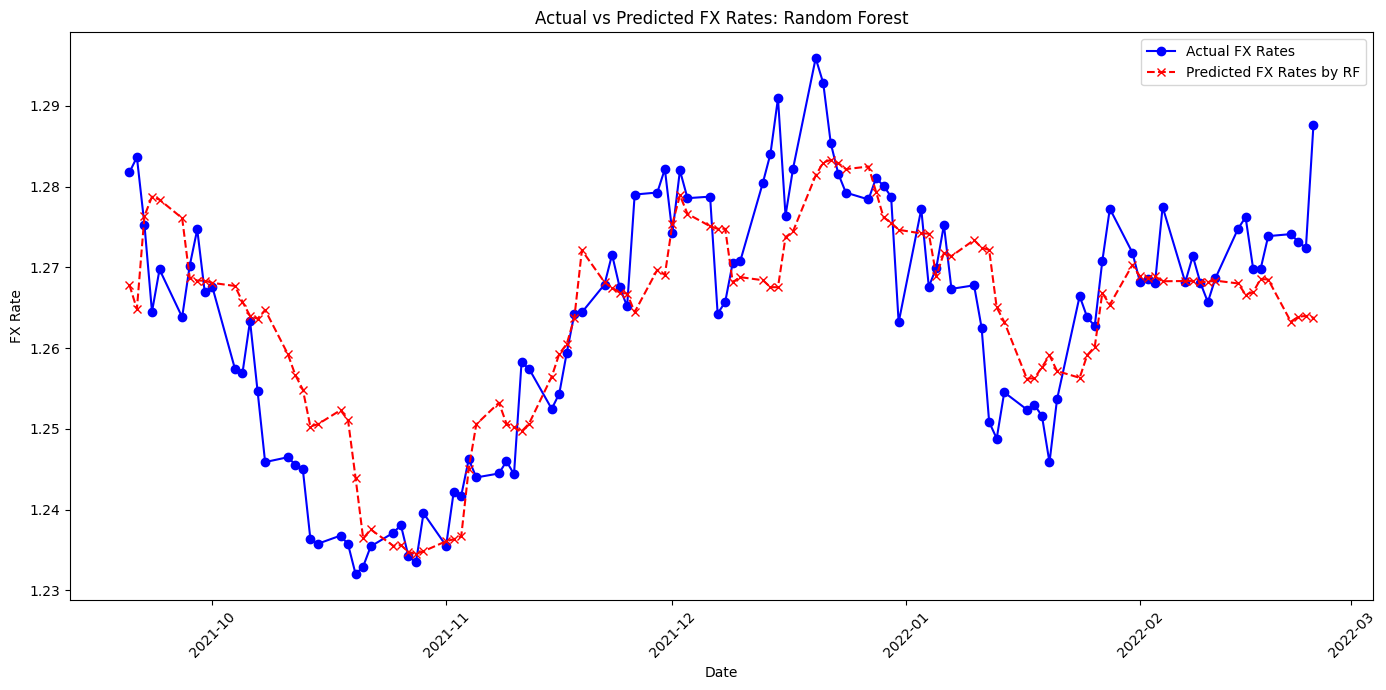

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test, label='Actual FX Rates', color='blue', marker='o')
plt.plot(test_dates, predictions_rf, label='Predicted FX Rates by RF', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted FX Rates: Random Forest')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test,
    'Predicted': predictions_rf
})

# Specify the file path and name
file_path = f"{selection}_rf_model_predictions.csv"

# Save the DataFrame to a CSV file
results_df.to_csv(file_path, index=False)

print(f'Results saved to {file_path}')


Results saved to CA_rf_model_predictions.csv


In [29]:
country_test_df = country_test_df.reset_index()

print(country_test_df.columns)

Index(['Date', 'CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE'], dtype='object')


First Model - MAE: 0.0090, RMSE: 0.0107
Second Model - MAE: 0.0066, RMSE: 0.0086


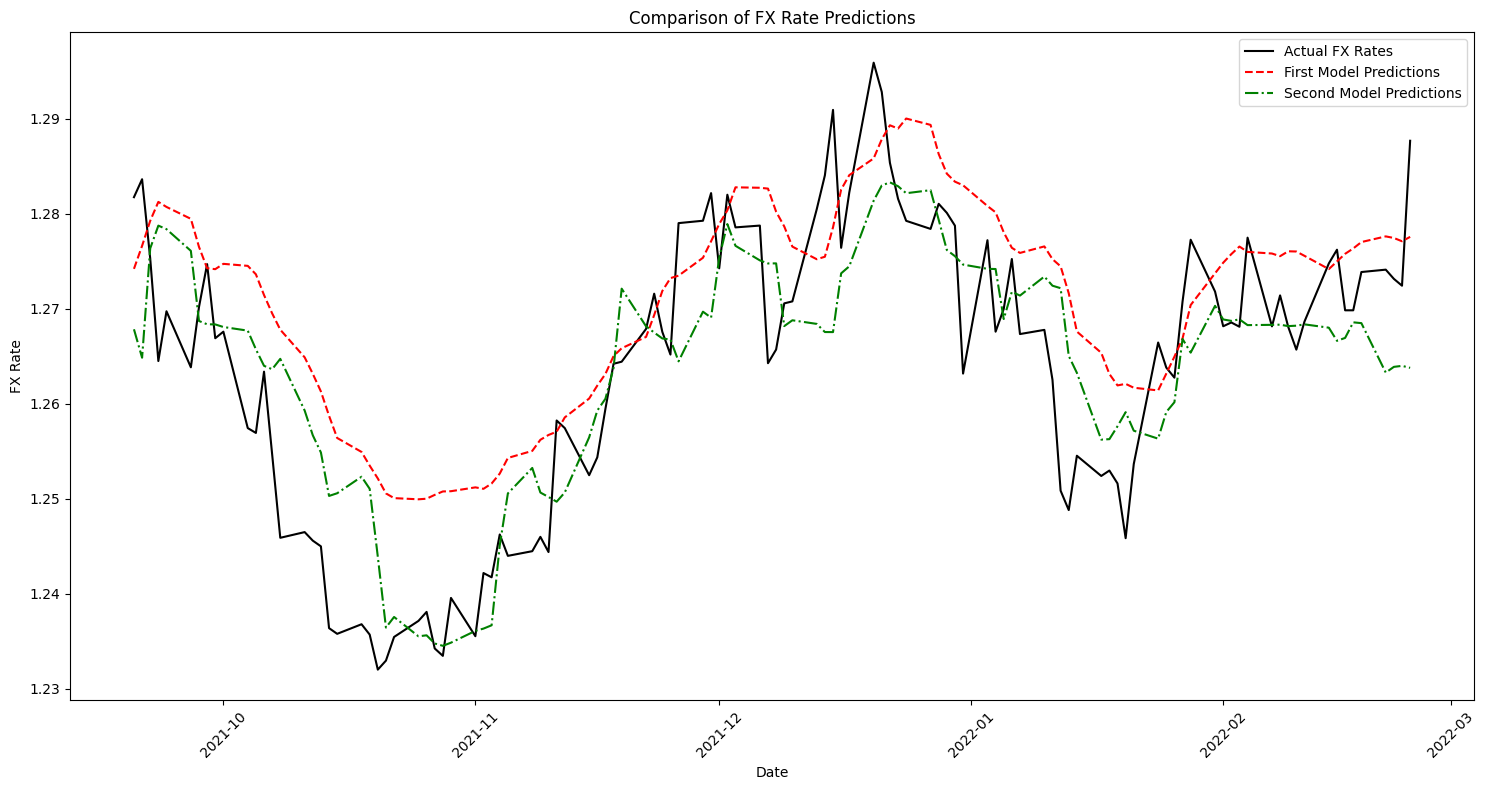

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the predictions from both models
first_model_df = pd.read_excel(f'{selection}_pred.xlsx', usecols="B:C", header=0)
first_model_df.columns = ['Date', 'Predicted_FX_First_Model']
first_model_df['Date'] = pd.to_datetime(first_model_df['Date'])

second_model_df = pd.read_csv(f"{selection}_rf_model_predictions.csv")
second_model_df['Date'] = pd.to_datetime(second_model_df['Date'])
second_model_df.rename(columns={'Predicted': 'Predicted_FX_Second_Model'}, inplace=True)

# Convert the 'Date' column in country_test_df to datetime if it's not already
country_test_df['Date'] = pd.to_datetime(country_test_df['Date'])

# Merge the DataFrames on the 'Date' column using 'inner' to avoid NaN values
comparison_df = country_test_df.merge(first_model_df, on='Date', how='inner').merge(second_model_df[['Date', 'Predicted_FX_Second_Model']], on='Date', how='inner')

# Proceed with your analysis and plotting
mae_first = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model'])
rmse_first = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model']))

mae_second = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model'])
rmse_second = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model']))

print(f'First Model - MAE: {mae_first:.4f}, RMSE: {rmse_first:.4f}')
print(f'Second Model - MAE: {mae_second:.4f}, RMSE: {rmse_second:.4f}')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(comparison_df['Date'], comparison_df[country_currency_column], label='Actual FX Rates', color='black')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_First_Model'], label='First Model Predictions', color='red', linestyle='--')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_Second_Model'], label='Second Model Predictions', color='green', linestyle='-.')
plt.title('Comparison of FX Rate Predictions')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


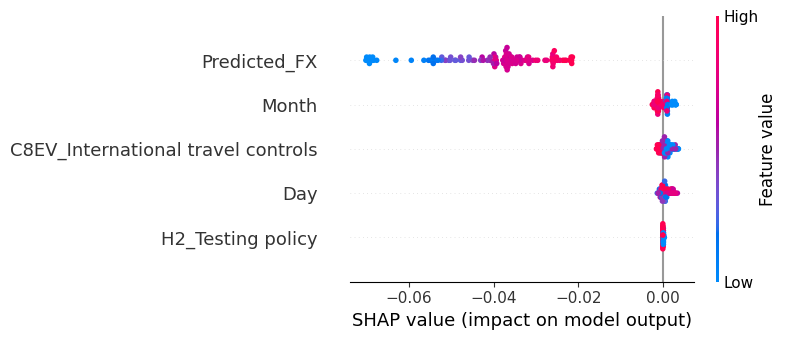

In [32]:
import shap

explainer = shap.TreeExplainer(rf_regressor)

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=features_columns)
